In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime


# 0. Functions

In [2]:

def daily_price(ticker, end, days_earlier=3, columns=['Close']):
    '''
    Returns a DataFrame of prices for ticker from Yahoo Finance API
    The close date is excluded!!!!
    Minimum 3 days window due to weekends and holidays.
    '''
    result_series = []

    for timestamp in end:
        start = timestamp - datetime.timedelta(days=days_earlier)

        obj = yf.Ticker(ticker)
        data = obj.history(start=start, end=timestamp)[columns]

        result_series.append(data[columns].values.mean())

    return pd.Series(result_series).values

In [3]:
def convert_national_currency(input_data=pd.DataFrame, currency=pd.DataFrame):
    '''
    Convert colums into national currency
    '''
    output_data = input_data.copy()

    for column in output_data.columns:
        if column not in ['shares', 'national_div', 'usd_div', 'usd_nat_currency', 'real_date', 'date']:
            output_data[column] = output_data[column].astype(float) * currency['usd_nat_currency']
            print('No - mark in row: ' + column)

    return output_data

In [4]:
def calculate_real_date(input):
    '''
    Calculate the rough estimated date when the quaterly report could be available
    '''
    result = []
    for timestamp in input['date']:
        if timestamp.month == 12:
            result.append(timestamp + datetime.timedelta(days=42))
        else:
            result.append(timestamp + datetime.timedelta(days=21))

    input['real_date'] = result
    return input

In [5]:
def filter_raw_data(input=pd.DataFrame):
    filtered = input[
                [
                'date',
                'real_date',
                'shares',
                'revenue',
                'cogs',
                'gross_profit',
                'net_profit',
                'cash',
                'acc_rec',
                'inventory',
                'curr_assets',
                'goodwill',
                'intangible_assets',
                'total_assets',
                'acc_pay',
                'short_term_debt',
                'current_debt',
                'curr_liab',
                'long_term_debt',
                'total_liab',
                'cash_from_operating_activities',
                'capex'
                ]
            ].copy()
    
    return filtered

In [6]:
def calculate_input_value_ratios(input=pd.DataFrame):
    input['eps'] = (input['net_profit'] * 4) / input['shares'] # quaterly corrected here --> multipled by 4
    input['bv_per_share'] = (input['total_assets']-input['total_liab']) / input['shares']
    input['fcf'] = (4 * input['cash_from_operating_activities']) - (input['capex'] * 4) # quaterly corrected here --> multipled by 4
    input['fcf_per_share'] = input['fcf'] / input['shares']

    return input

In [7]:
def ratios_input_filter(input=pd.DataFrame):
    ratios = input[
                [
                'date',
                'real_date',
                'revenue',
                'eps',
                'bv_per_share',
                'shares',
                'fcf',
                'fcf_per_share'
                ]
            ].copy()

    return ratios

In [8]:
def evaluate_performance(input=pd.DataFrame, output=pd.DataFrame):
    # evauleat short term debt
    output['current_ratio'] = input['curr_assets'] / input['curr_liab']
    output['quick_ratio'] = (input['curr_assets'] - input['inventory']) / input['curr_liab']
    output['cash_ratio'] = input['cash'] / input['curr_liab']
    #evaluate long term debt
    output['debt_to_equity'] = input['total_liab'] / (input['total_assets'] - input['total_liab'])
    output['equity_ratio'] = (input['total_assets'] - input['total_liab']) / input['total_assets']
    output['debt_ratio'] = input['total_liab'] / input['total_assets']
    # evlauate management --> based on efficiency ratios
    output['acc_rec_ratio'] = (4 * input['revenue']) / input['acc_rec']
    output['acc_pay_ratio'] = (-4 * input['cogs']) / input['acc_pay']
    output['cash_turnover'] = (4 * input['revenue']) / input['cash']
    output['inventory_turnover'] = (-4 * input['cogs']) / input['inventory']
    # test economy moat
    output['gross_profit_margin'] = input['gross_profit'] / input['revenue']
    output['net_profit_margin'] = input['net_profit'] / input['revenue']
    output['roa'] = (4 * input['net_profit']) / input['total_assets']
    output['roe'] = (4 * input['net_profit']) / (input['total_assets'] - input['total_liab'])

    return output

In [9]:
def price_ratios(input=pd.DataFrame):
    '''
    The original metrics have been develoed to annual data. I use quaterly data.
    '''
    input['pe_ratio'] = input['share_price'] / input['eps'] # previously multiplied by 4 (quaterly correction)
    input['pb_ratio'] = input['share_price'] / input['bv_per_share'] # don't need to quaterly correct (Income Statement data)
    input['ps_ratio'] = (input['share_price'] * input['shares']) / (input['revenue'] * 4) # quaterly corrected here --> multipled by 4
    input['pfcf_ratio'] = (input['share_price'] * input['shares']) / input['fcf']  # previously multiplied by 4 (quaterly correction)

    return input

# 1. Load raw input
## Hardcoded block

In [10]:
currency_pair = 'NOK=X'
share_name = 'LSG.OL'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount
## Pull historical USD national currency rates to dividend & calculate historical dividend in USD

In [11]:
ticker_share = yf.Ticker(share_name)
dividend = ticker_share.history(period='max', interval="1wk")
dividend = dividend[dividend['Dividends'] > 0]
dividend = dividend.rename(columns={'Dividends': 'local_amount'})

dividend['real_date'] = dividend.index 
dividend['real_date'] = dividend['real_date'].dt.tz_localize(None)

dividend = dividend[['real_date', 'local_amount']]

dividend['usd_rate'] = daily_price(ticker=currency_pair, end=dividend['real_date'], days_earlier=3)
dividend['currency'] = [currency_pair.split(sep='=')[0] for x in range(len(dividend))]
dividend['usd_dividend'] = dividend['local_amount'] / dividend['usd_rate']

NOK=X: No price data found, symbol may be delisted (1d 2003-05-16 00:00:00 -> 2003-05-19 00:00:00)
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_12818/3975615225.py:15: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
dividend.to_csv(f"../csv_files/{share_name}_dividend.csv")
dividend.head()

,real_date,local_amount,usd_rate,currency,usd_dividend
Date,,,,,
2003-05-19 00:00:00+02:00,2003-05-19,0.060,NaN,NOK,NaN
2004-05-24 00:00:00+02:00,2004-05-24,0.060,6.8727,NOK,0.008730
2005-05-23 00:00:00+02:00,2005-05-23,0.080,6.4594,NOK,0.012385
2006-05-22 00:00:00+02:00,2006-05-22,0.014,6.1060,NOK,0.002293
2007-05-21 00:00:00+02:00,2007-05-21,0.400,6.0416,NOK,0.066208


## Extend your input statement table with historical dividend data and calculate share prices!

# 1.2. Raw input statement data

In [23]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])

data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,financing_cf_item,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares
0,2001-03-31,650,-611,39,-14,0,-13,5,16,-4,...,-13,0,0,0,-13,0,-3,0.4,0.066208,317.184012
1,2001-06-30,610,-575,35,-11,0,-14,2,12,-3,...,-16,0,0,0,-16,0,1,0.4,0.066208,317.184012
2,2001-09-30,560,-518,43,-16,0,-16,-1,10,-3,...,158,0,0,0,158,0,11,0.4,0.066208,317.184012
3,2001-12-31,710,-629,81,-27,0,-22,-14,19,-7,...,-19,0,0,0,-19,0,-15,0.4,0.066208,317.184012
4,2002-03-31,579,-525,53,-21,0,-17,-5,11,-3,...,-10,0,0,0,-10,0,48,0.4,0.066208,317.184012


## Calculate date when quaterly reports could be available

In [24]:
data = calculate_real_date(data)
data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares,real_date
0,2001-03-31,650,-611,39,-14,0,-13,5,16,-4,...,0,0,0,-13,0,-3,0.4,0.066208,317.184012,2001-04-21
1,2001-06-30,610,-575,35,-11,0,-14,2,12,-3,...,0,0,0,-16,0,1,0.4,0.066208,317.184012,2001-07-21
2,2001-09-30,560,-518,43,-16,0,-16,-1,10,-3,...,0,0,0,158,0,11,0.4,0.066208,317.184012,2001-10-21
3,2001-12-31,710,-629,81,-27,0,-22,-14,19,-7,...,0,0,0,-19,0,-15,0.4,0.066208,317.184012,2002-02-11
4,2002-03-31,579,-525,53,-21,0,-17,-5,11,-3,...,0,0,0,-10,0,48,0.4,0.066208,317.184012,2002-04-21


## Pull historical average USD national currency rates and add to the dataframe

In [25]:
data['usd_nat_currency'] = daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

data.head()

NOK=X: Data doesn't exist for startDate = 978220800, endDate = 985993200
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_12818/3975615225.py:15: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
NOK=X: Data doesn't exist for startDate = 986079600, endDate = 993855600
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_12818/3975615225.py:15: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
NOK=X: No price data found, symbol may be delisted (1d 2003-07-02 00:00:00 -> 2003-09-30 00:00:00)
/var/folders/ds/_qwh_w1

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares,real_date,usd_nat_currency
0,2001-03-31,650,-611,39,-14,0,-13,5,16,-4,...,0,0,-13,0,-3,0.4,0.066208,317.184012,2001-04-21,NaN
1,2001-06-30,610,-575,35,-11,0,-14,2,12,-3,...,0,0,-16,0,1,0.4,0.066208,317.184012,2001-07-21,NaN
2,2001-09-30,560,-518,43,-16,0,-16,-1,10,-3,...,0,0,158,0,11,0.4,0.066208,317.184012,2001-10-21,8.923518
3,2001-12-31,710,-629,81,-27,0,-22,-14,19,-7,...,0,0,-19,0,-15,0.4,0.066208,317.184012,2002-02-11,8.897403
4,2002-03-31,579,-525,53,-21,0,-17,-5,11,-3,...,0,0,-10,0,48,0.4,0.066208,317.184012,2002-04-21,8.905573


In [26]:
# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]
data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares,real_date,usd_nat_currency
2,2001-09-30,560,-518,43,-16,0,-16,-1,10,-3,...,0,0,158,0,11,0.4,0.066208,317.184012,2001-10-21,8.923518
3,2001-12-31,710,-629,81,-27,0,-22,-14,19,-7,...,0,0,-19,0,-15,0.4,0.066208,317.184012,2002-02-11,8.897403
4,2002-03-31,579,-525,53,-21,0,-17,-5,11,-3,...,0,0,-10,0,48,0.4,0.066208,317.184012,2002-04-21,8.905573
5,2002-06-30,582,-535,47,-19,0,-18,-3,7,-2,...,0,0,293,0,257,0.4,0.066208,317.184012,2002-07-21,8.194440
6,2002-09-30,611,-555,57,-26,0,-23,-2,5,-2,...,0,0,-4,0,10,0.4,0.066208,317.184012,2002-10-21,7.532147


## Convert USD values related to IS, BS, CFS to national currency

In [27]:
# convert columns into national currency
data_nok = convert_national_currency(input_data=data, currency=data)
data_nok.head()

No - mark in row: revenue
No - mark in row: cogs
No - mark in row: gross_profit
No - mark in row: sell_gen_adm_exp
No - mark in row: r&d
No - mark in row: other_income
No - mark in row: financial_income
No - mark in row: profit_before_tax
No - mark in row: tax
No - mark in row: net_profit
No - mark in row: minority_interest
No - mark in row: net_profit_minority_int
No - mark in row: cash
No - mark in row: acc_rec
No - mark in row: short_invest
No - mark in row: inventory
No - mark in row: prep_expanses
No - mark in row: other_curr_assets
No - mark in row: curr_assets
No - mark in row: ppe
No - mark in row: long_term_invest
No - mark in row: goodwill
No - mark in row: intangible_assets
No - mark in row: other_long_assets
No - mark in row: non_current_assets'
No - mark in row: total_assets
No - mark in row: acc_pay
No - mark in row: short_term_debt
No - mark in row: acc_expenses
No - mark in row: current_debt
No - mark in row: other_curr_liab
No - mark in row: curr_liab
No - mark in row:

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,national_div,usd_div,shares,real_date,usd_nat_currency
2,2001-09-30,4997.170191,-4622.382427,383.711283,-142.776291,0.0,-142.776291,-8.923518,89.235182,-26.770555,...,0.0,0.0,1409.915875,0.0,98.158700,0.4,0.066208,317.184012,2001-10-21,8.923518
3,2001-12-31,6317.156290,-5596.466628,720.689661,-240.229887,0.0,-195.742871,-124.563645,169.050661,-62.281823,...,0.0,0.0,-169.050661,0.0,-133.461048,0.4,0.066208,317.184012,2002-02-11,8.897403
4,2002-03-31,5156.326765,-4675.425824,471.995369,-187.017033,0.0,-151.394741,-44.527865,97.961303,-26.716719,...,0.0,0.0,-89.055730,0.0,427.467504,0.4,0.066208,317.184012,2002-04-21,8.905573
5,2002-06-30,4769.164100,-4384.025419,385.138682,-155.694361,0.0,-147.499921,-24.583320,57.361080,-16.388880,...,0.0,0.0,2400.970930,0.0,2105.971089,0.4,0.066208,317.184012,2002-07-21,8.194440
6,2002-09-30,4602.142081,-4180.341825,429.332404,-195.835833,0.0,-173.239391,-15.064295,37.660737,-15.064295,...,0.0,0.0,-30.128590,0.0,75.321474,0.4,0.066208,317.184012,2002-10-21,7.532147


# 2. Filter out unnecesary columns

In [28]:
filtered_nok = filter_raw_data(data_nok)

# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [29]:
filtered_nok = calculate_input_value_ratios(filtered_nok)

## Calculate input values to value ratios

In [30]:
ratios_nok = ratios_input_filter(filtered_nok)

In [31]:
ratios_nok = evaluate_performance(input=filtered_nok, output=ratios_nok)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [33]:

obj = yf.Ticker(share_name)
yar_share_price = obj.history(interval="1wk", start=data.date.min(), end=pd.Timestamp.now())
# add new date column due to pd.merge_asof match
yar_share_price['real_date'] = yar_share_price.index
# remove localization (timezone) to let merge the two columns
yar_share_price['real_date'] = yar_share_price['real_date'].dt.tz_localize(None)
# add share price column and keep the date and share prices
yar_share_price['share_price'] = yar_share_price['Close']
yar_share_price = yar_share_price[['real_date', 'share_price']]

yar_share_price.tail()

,real_date,share_price
Date,,
2024-01-08 00:00:00+01:00,2024-01-08,43.500000
2024-01-15 00:00:00+01:00,2024-01-15,43.860001
2024-01-22 00:00:00+01:00,2024-01-22,41.860001
2024-01-29 00:00:00+01:00,2024-01-29,42.000000
2024-02-05 00:00:00+01:00,2024-02-05,42.400002


## Merge the statement dataset with share prices

In [34]:
merged_nok = pd.merge_asof(left=yar_share_price, right=ratios_nok, on='real_date', direction='backward')
# drop rows with np.Nan and reset index
merged_nok = merged_nok.dropna()
merged_nok = merged_nok.reset_index(drop=True)
merged_nok.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2002-10-21,0.990349,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,0.570384,0.429616,7.808307,inf,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231
1,2002-10-28,0.965590,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,0.570384,0.429616,7.808307,inf,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231
2,2002-11-18,0.891314,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,0.570384,0.429616,7.808307,inf,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231
3,2002-12-16,0.896266,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,0.570384,0.429616,7.808307,inf,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231
4,2002-12-23,0.965590,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,0.570384,0.429616,7.808307,inf,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [35]:
merged_nok = price_ratios(merged_nok)
merged_nok.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
0,2002-10-21,0.990349,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231,3.475358,0.066834,0.017064,0.306649
1,2002-10-28,0.965590,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231,3.388474,0.065163,0.016637,0.298983
2,2002-11-18,0.891314,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231,3.127823,0.060150,0.015358,0.275984
3,2002-12-16,0.896266,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231,3.145200,0.060485,0.015443,0.277518
4,2002-12-23,0.965590,2002-09-30,4602.142081,0.284963,14.818086,317.184012,1024.372051,3.229583,2.681818,...,7.188235,40.363636,0.09329,0.00491,0.010969,0.019231,3.388474,0.065163,0.016637,0.298983


# Calculate Dividend yield and currency-share price correlation

In [36]:
obj = yf.Ticker(currency_pair)
obj2 = yf.Ticker(share_name)
usd_nok = obj.history(interval="1d", start=merged_nok['real_date'].min(), end=pd.Timestamp.now())
usd_nok['date'] = usd_nok.index
usd_nok['date'] = usd_nok['date'].dt.tz_localize(None)
usd_nok['currency_rate'] = usd_nok['Close']

In [37]:
yar_all_price = obj2.history(interval="1d", start=merged_nok['real_date'].min(), end=pd.Timestamp.now())
yar_all_price['date'] = yar_all_price.index
yar_all_price['date'] = yar_all_price['date'].dt.tz_localize(None)
yar_all_price['share_price'] = yar_all_price['Close']
yar_all_price['dividend_yield'] = yar_all_price['Dividends'] * 100 / yar_all_price['Close']

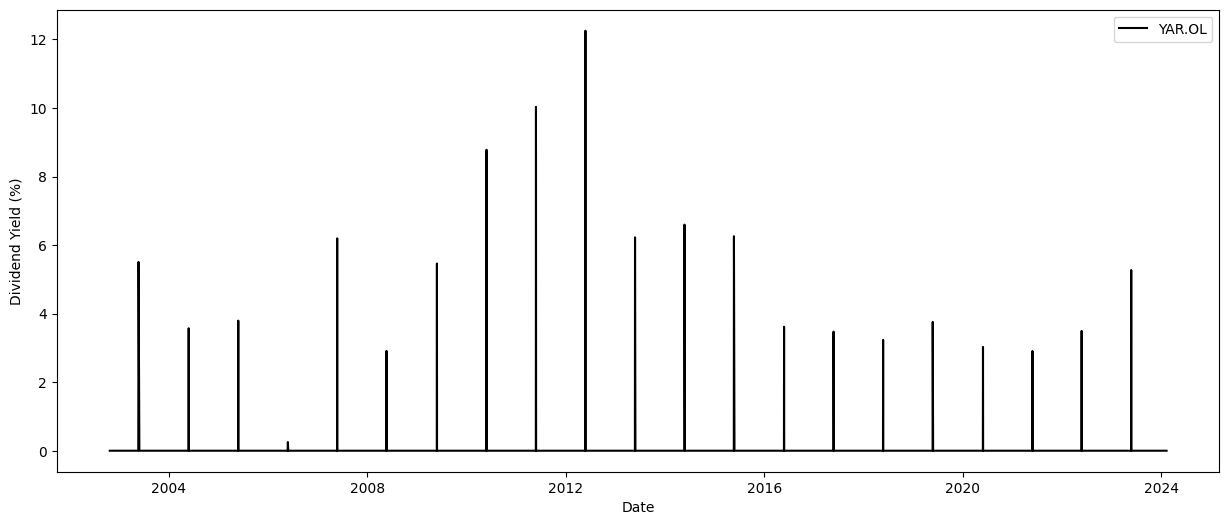

In [38]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(yar_all_price.index, yar_all_price['dividend_yield'], color='k', label='YAR.OL')

ax1.set_xlabel('Date')
ax1.set_ylabel('Dividend Yield (%)', color='k')

plt.legend()
plt.show()

In [39]:
share_price_currency_rate_correlation = pd.merge_asof(left=usd_nok, right=yar_all_price, on='date')
share_price_currency_rate_correlation.index = share_price_currency_rate_correlation['date']
share_price_currency_rate_correlation = share_price_currency_rate_correlation[['currency_rate', 'share_price']]

share_price_currency_rate_correlation.corr()['share_price']

currency_rate    0.821115
share_price      1.000000
Name: share_price, dtype: float64

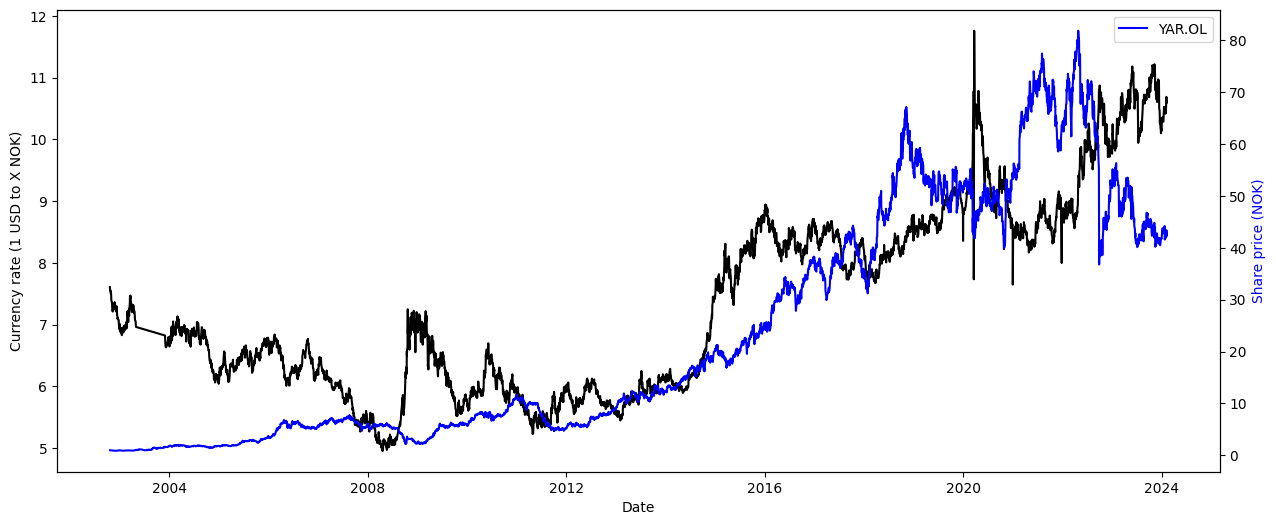

In [40]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
ax1.plot(usd_nok.index, usd_nok['Close'], color='k', label='USD / NOK')
ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label='YAR.OL')

ax1.set_xlabel('Date')
ax1.set_ylabel('Currency rate (1 USD to X NOK)', color='k')
ax2.set_ylabel('Share price (NOK)', color='b')

plt.legend()
plt.show()

# Share price and value ratios

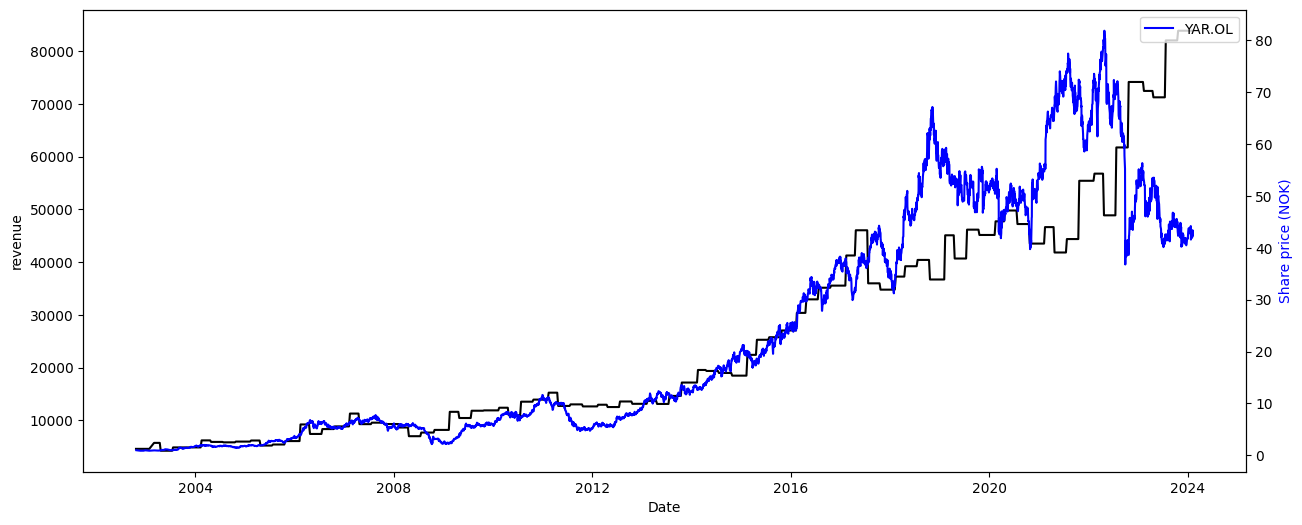

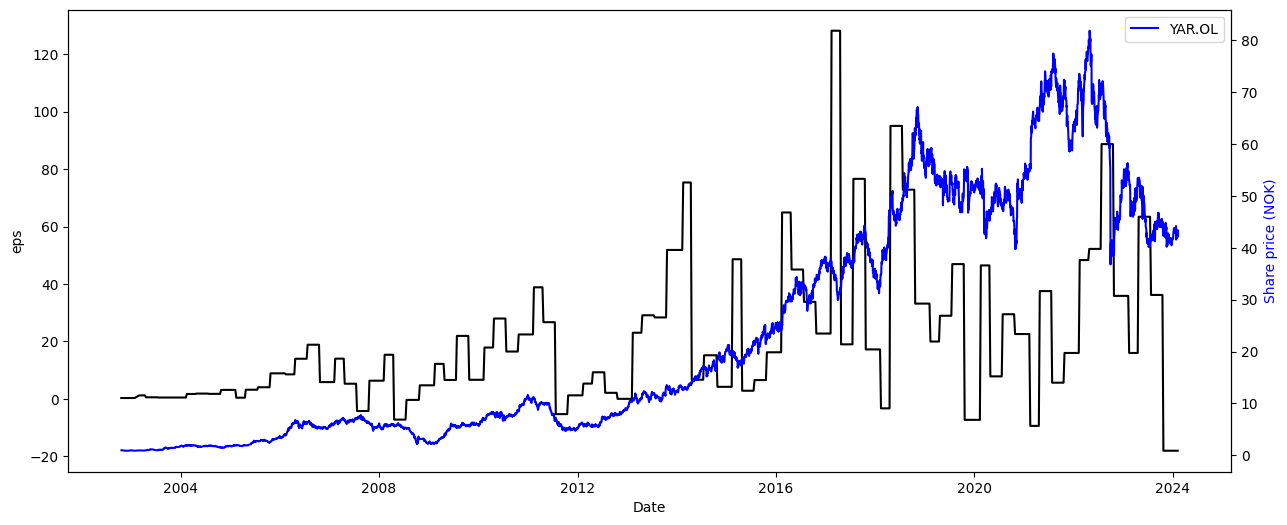

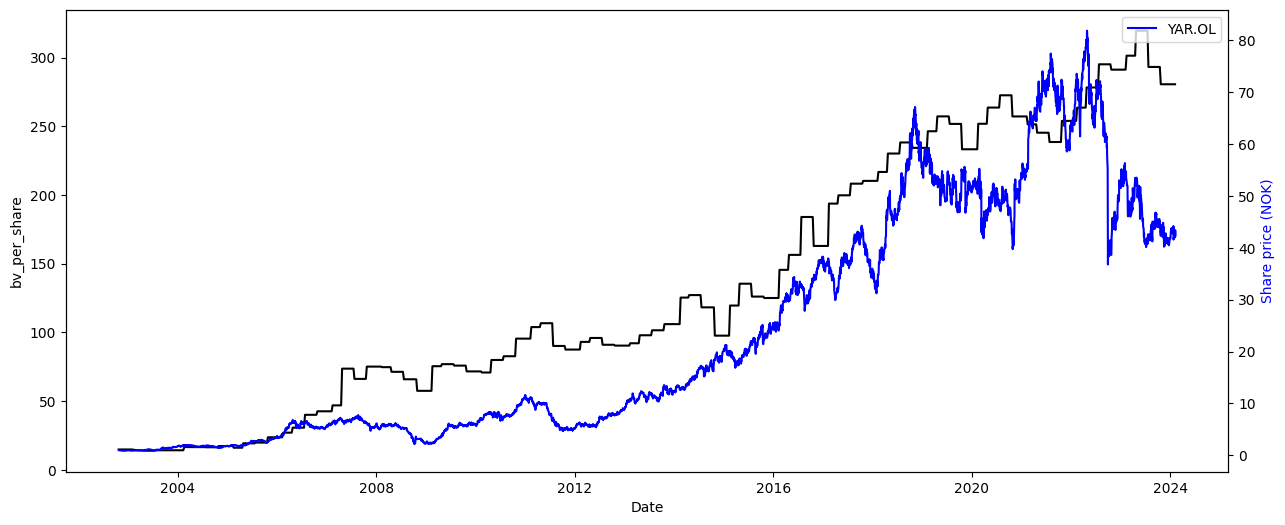

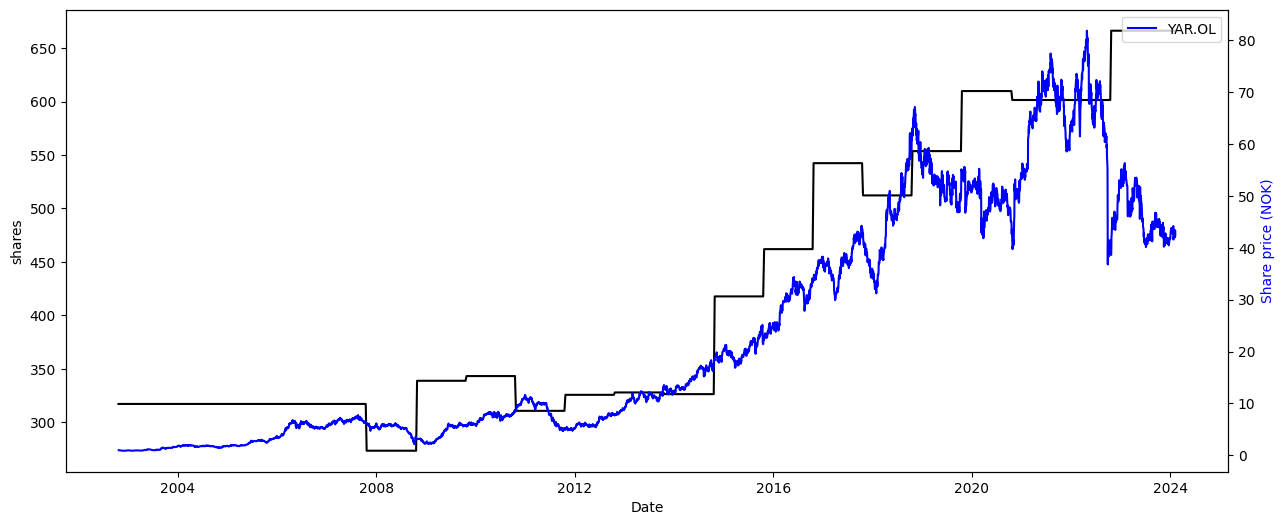

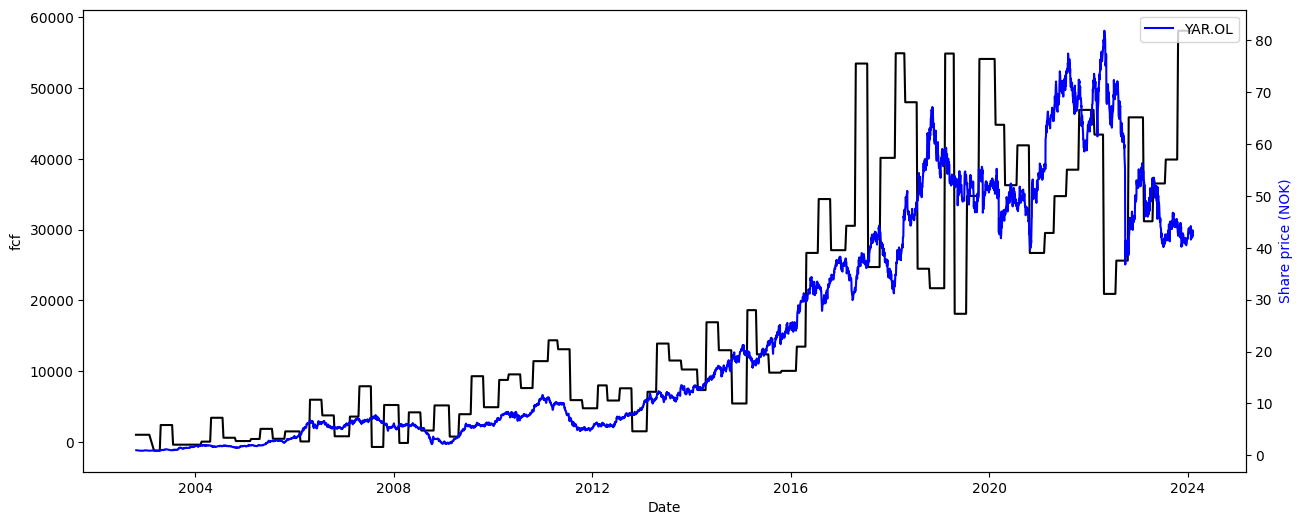

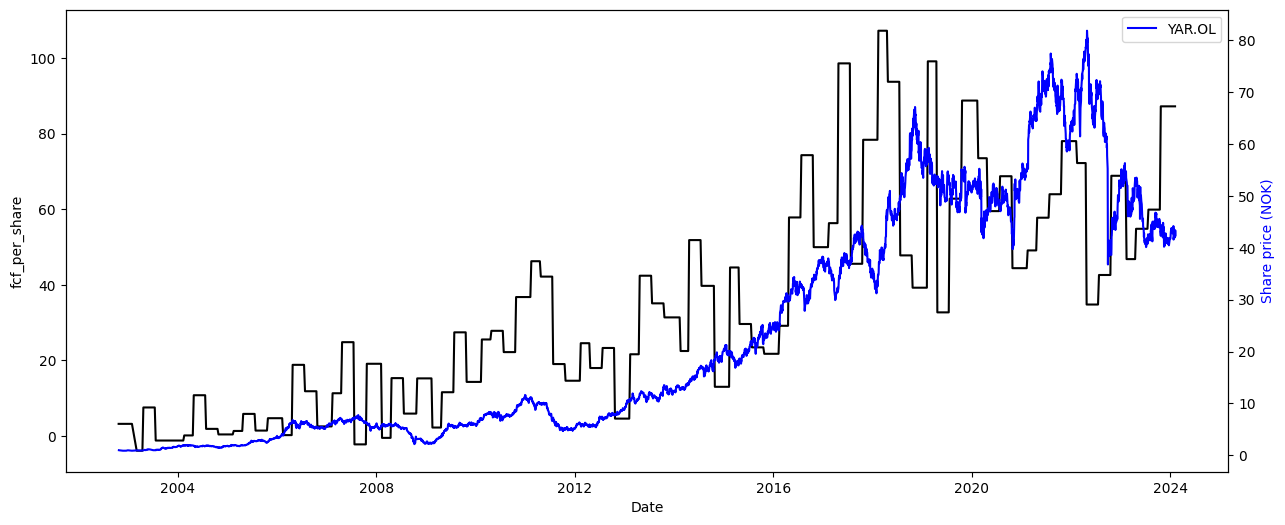

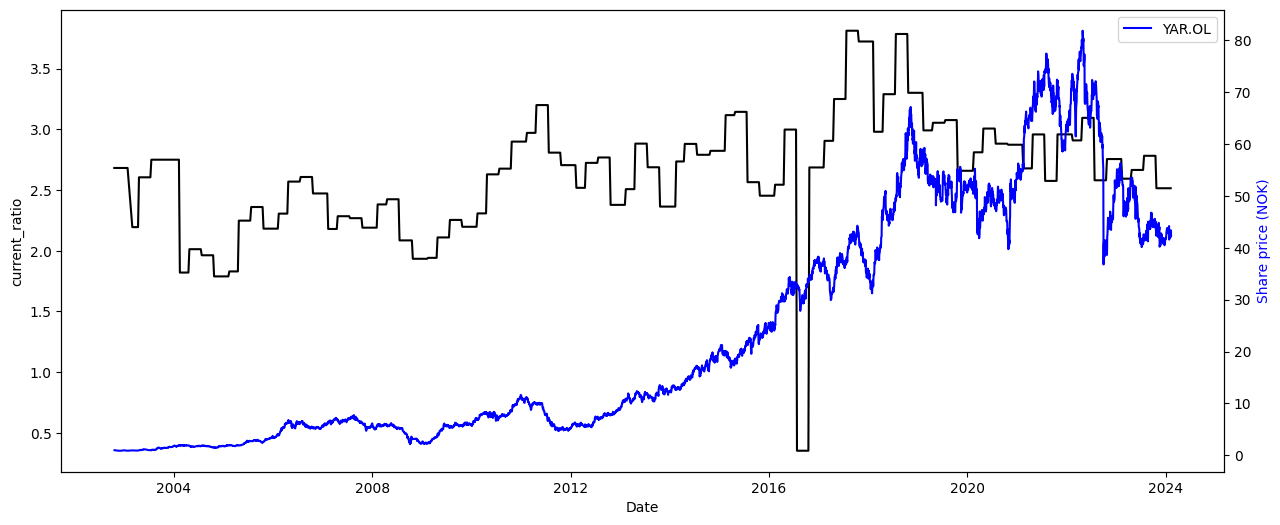

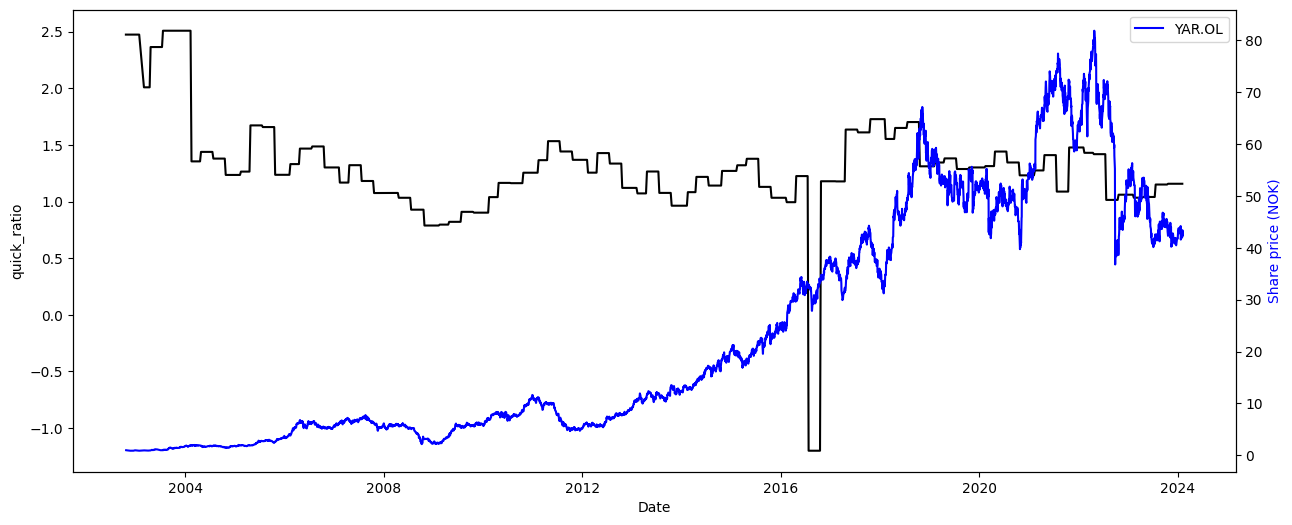

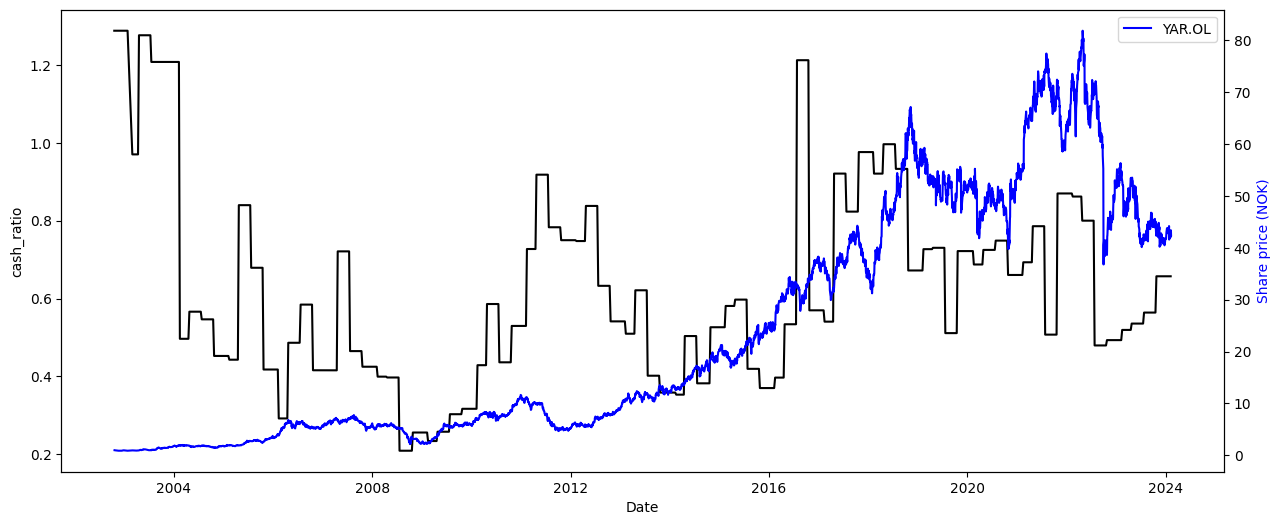

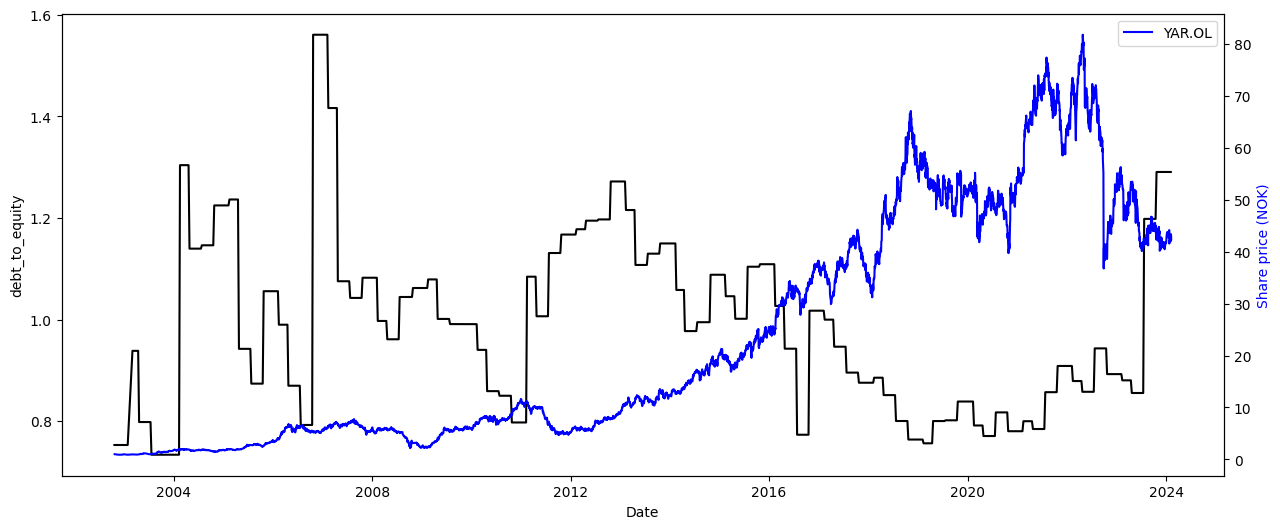

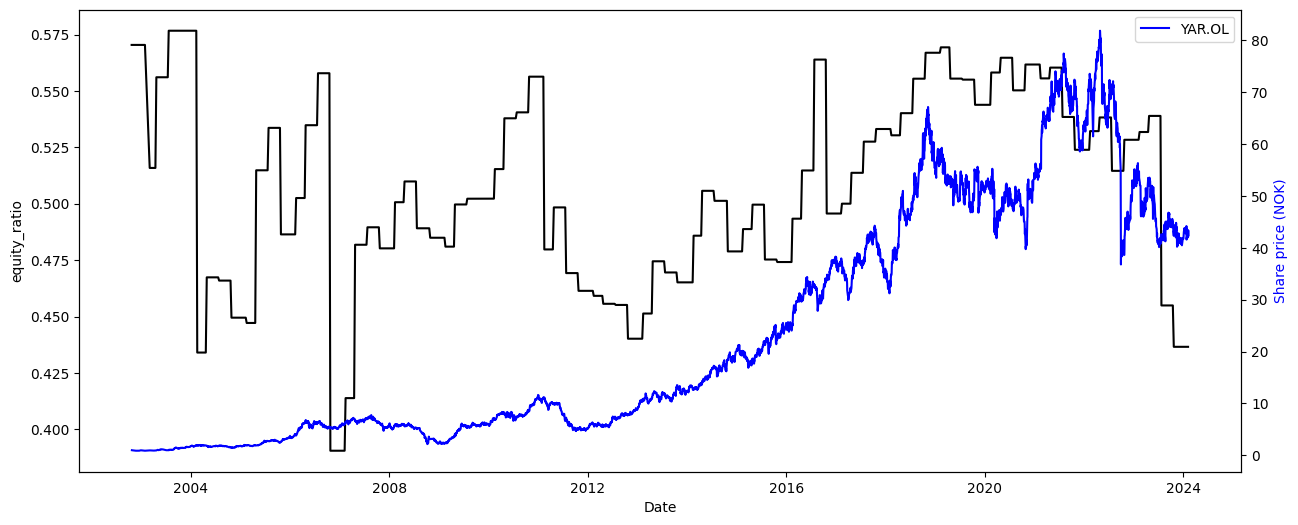

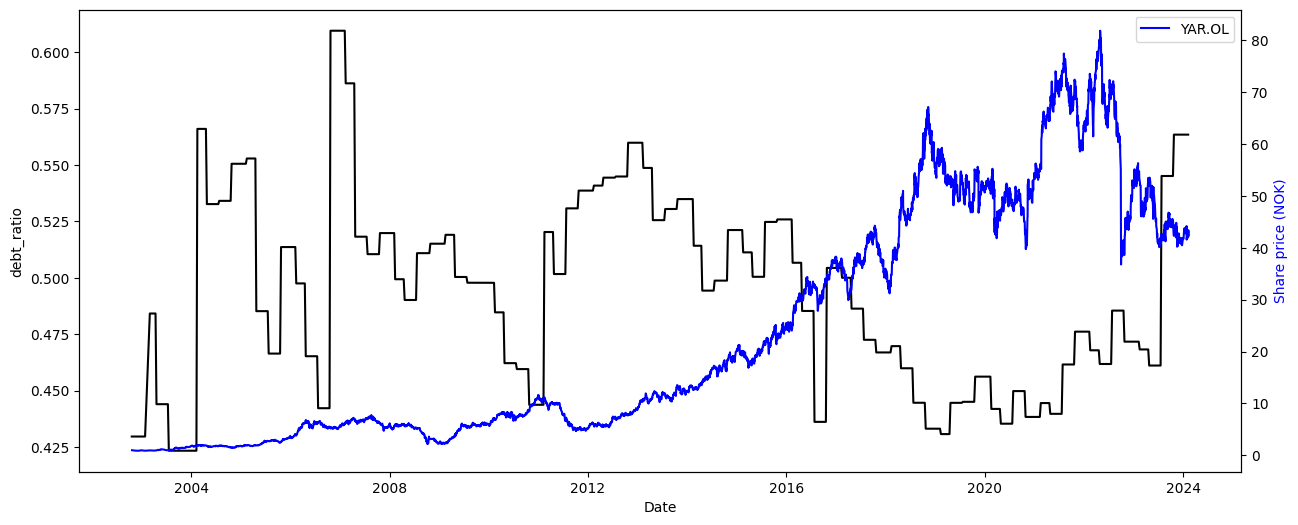

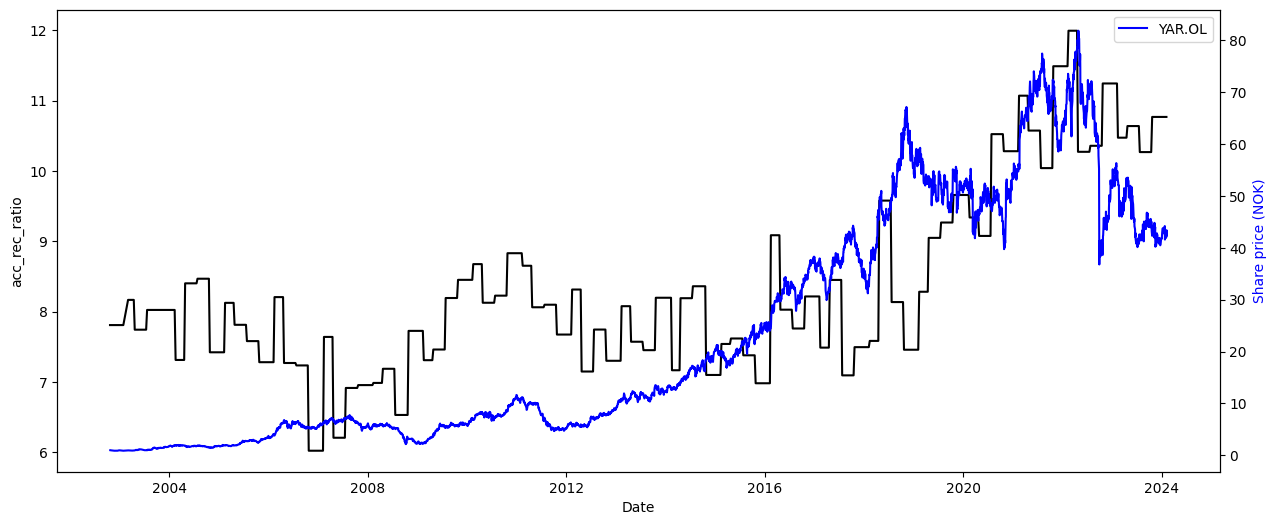

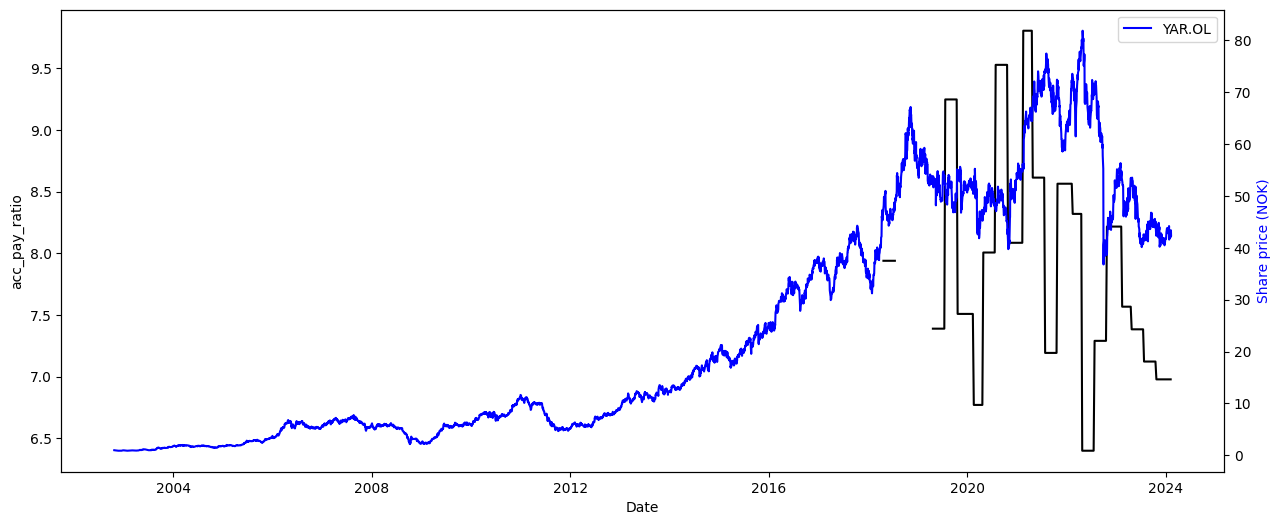

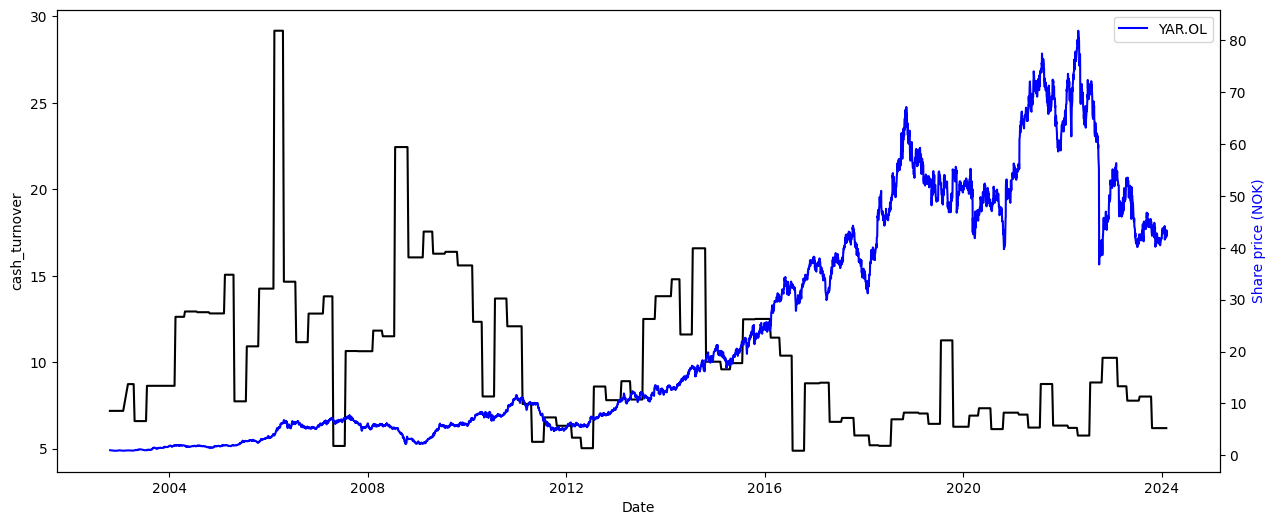

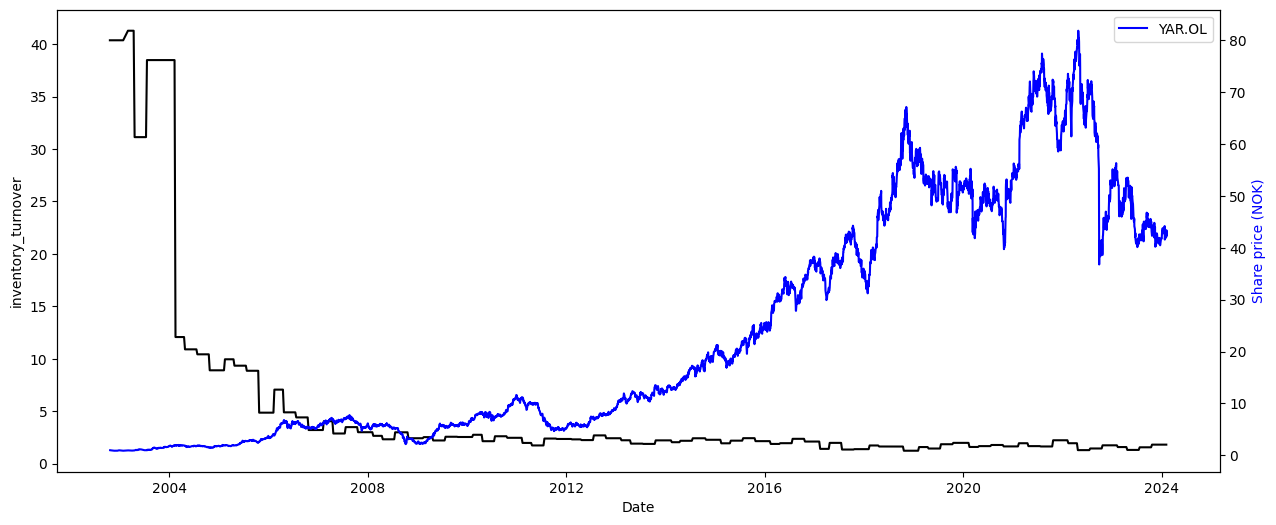

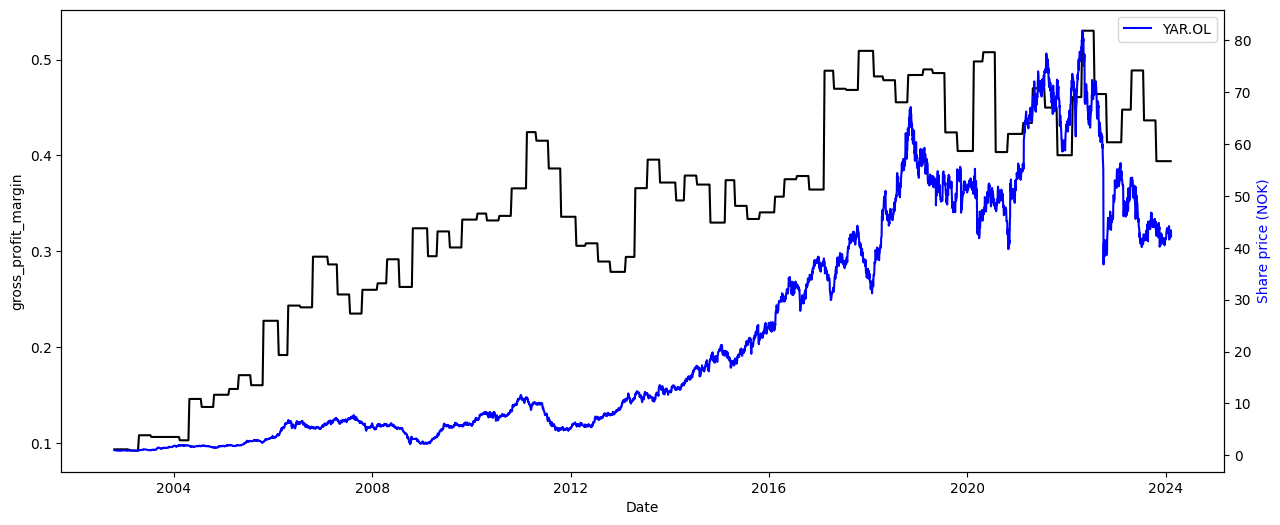

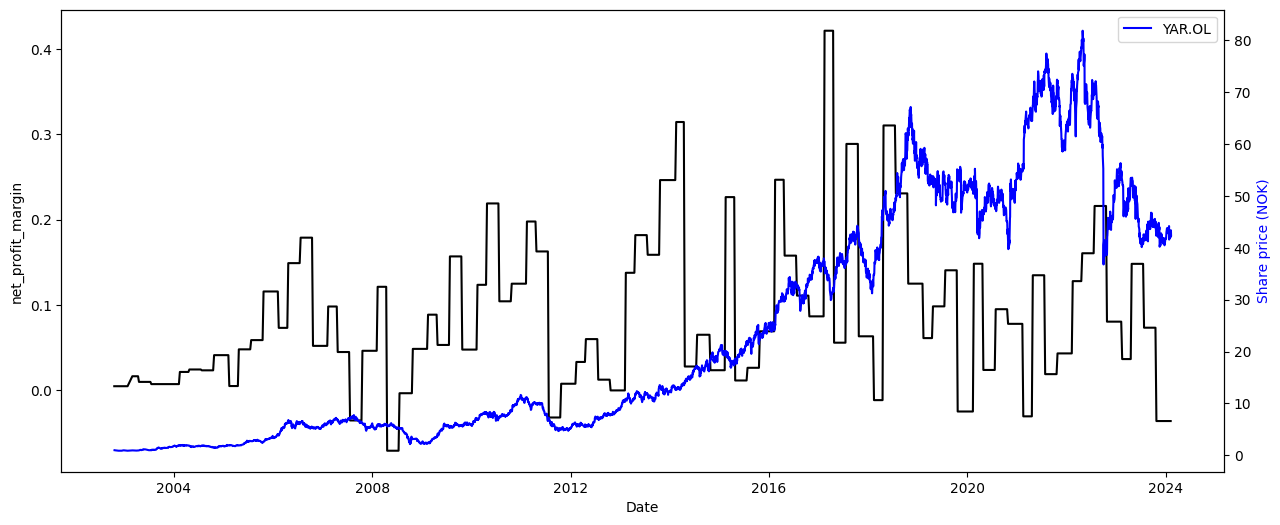

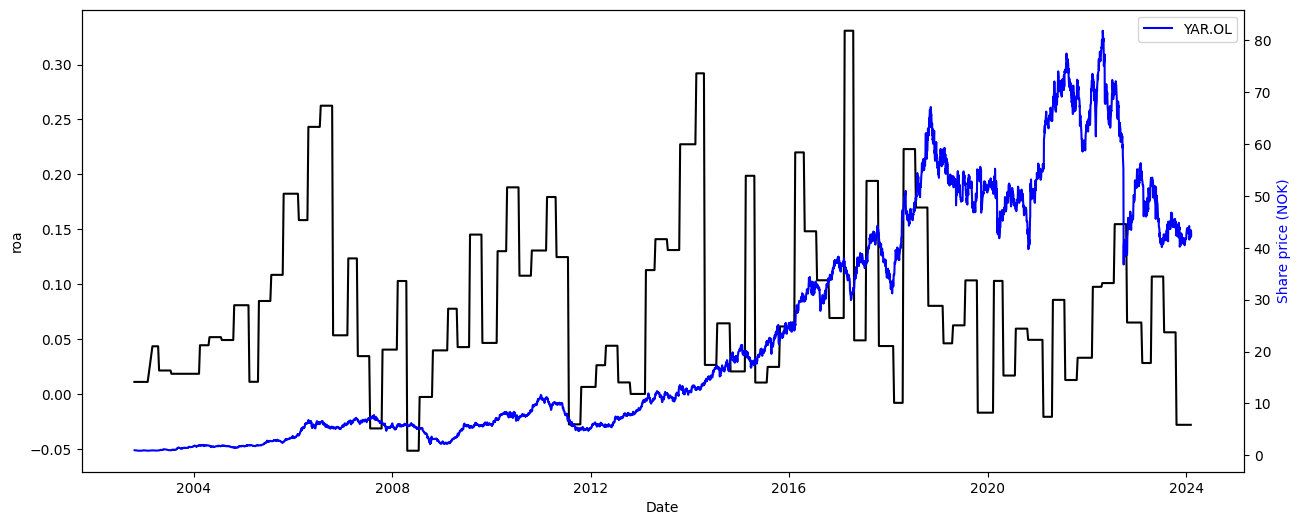

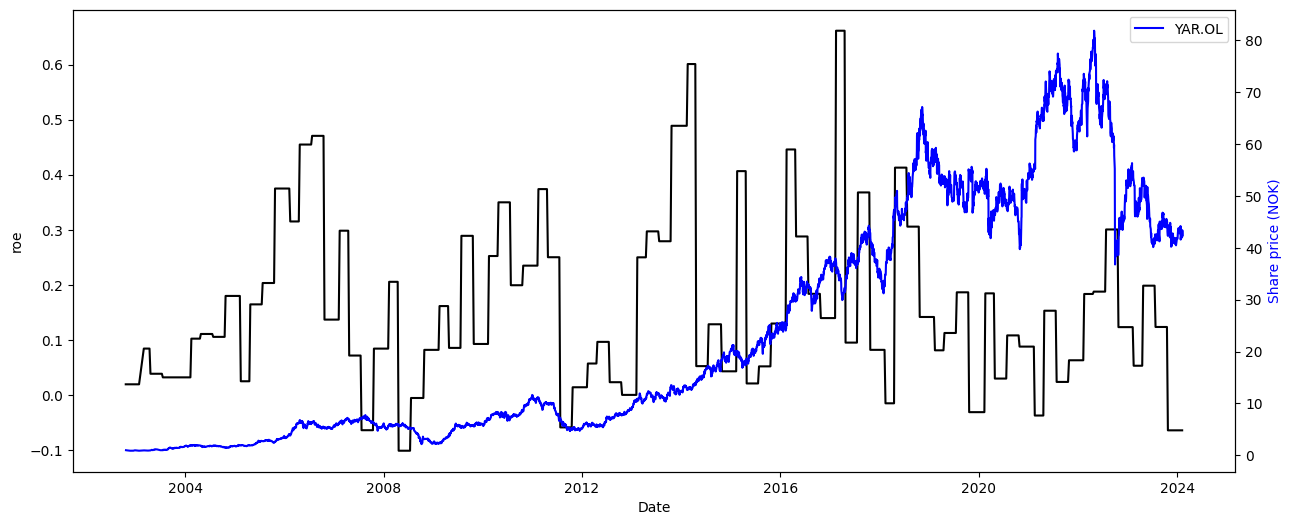

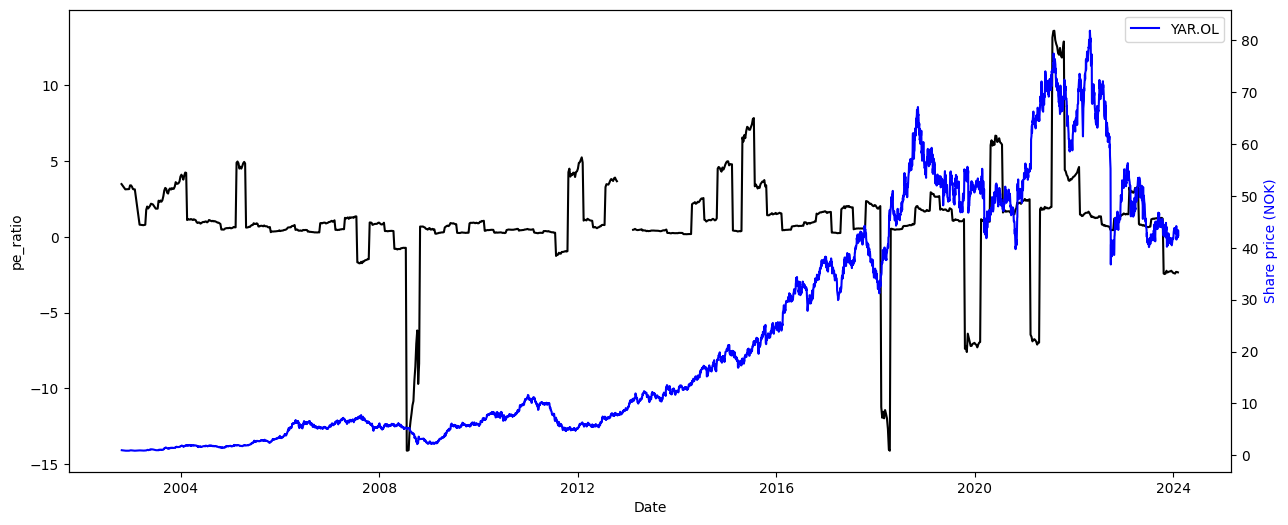

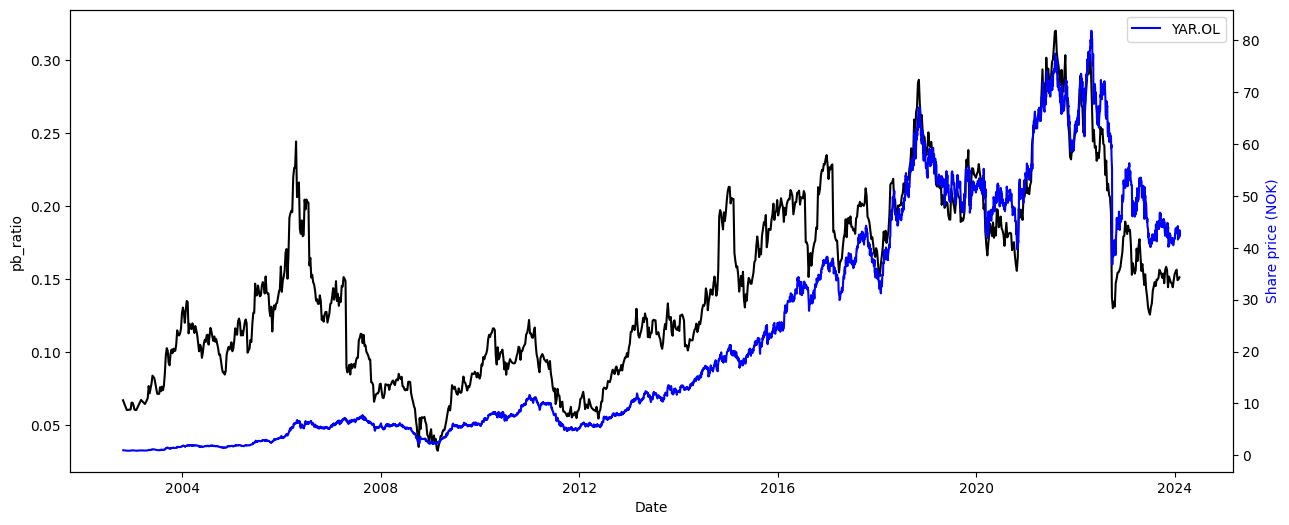

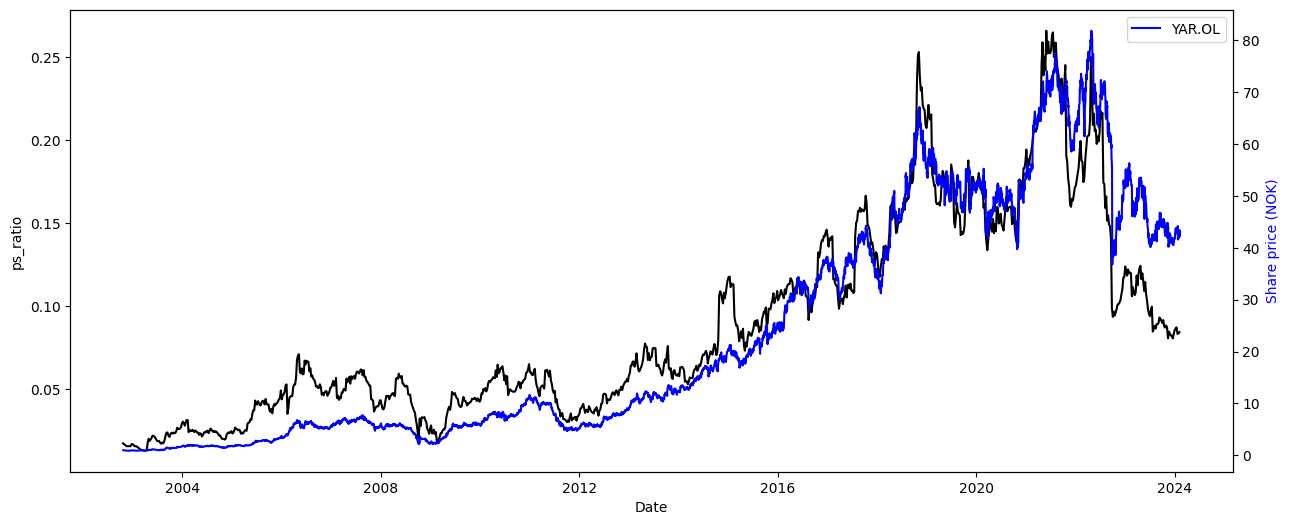

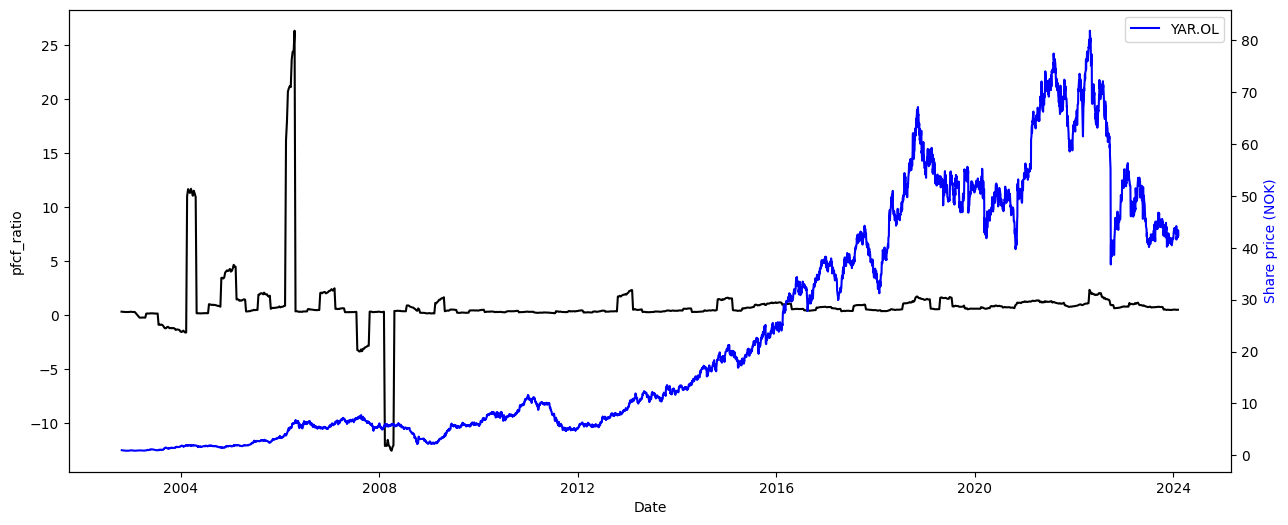

In [41]:
for column in merged_nok.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nok['real_date'], merged_nok[column], color='k', label=merged_nok)
    ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label='YAR.OL')

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (NOK)', color='b')

    plt.legend()
    plt.show()

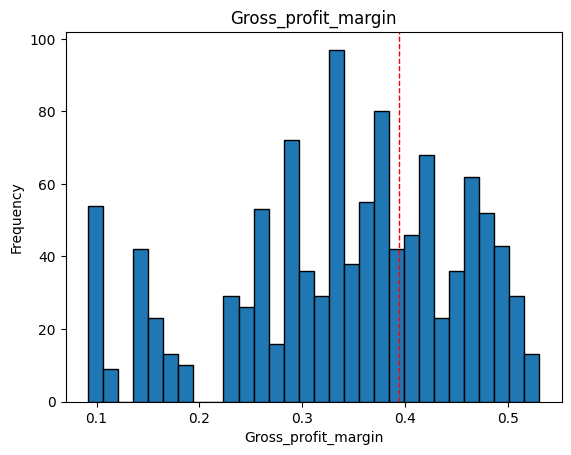

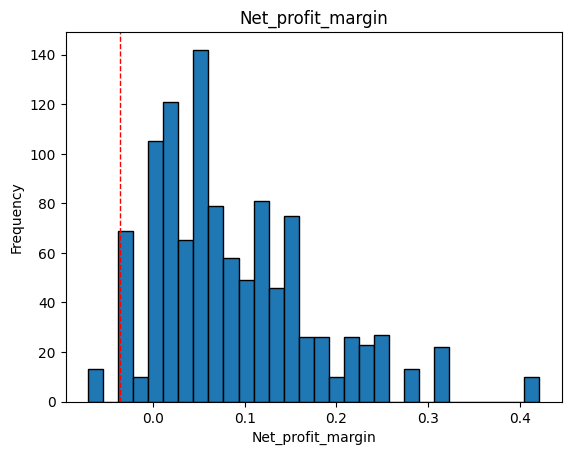

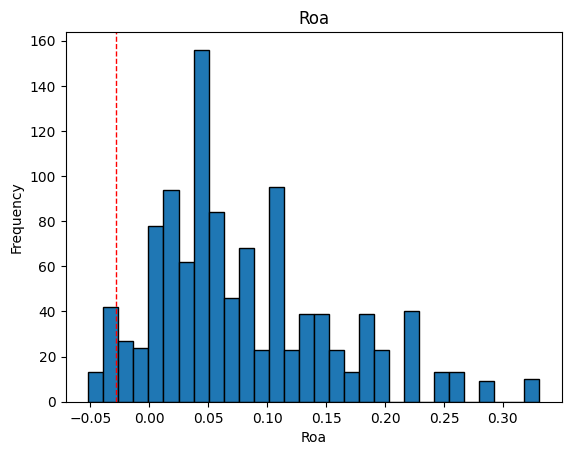

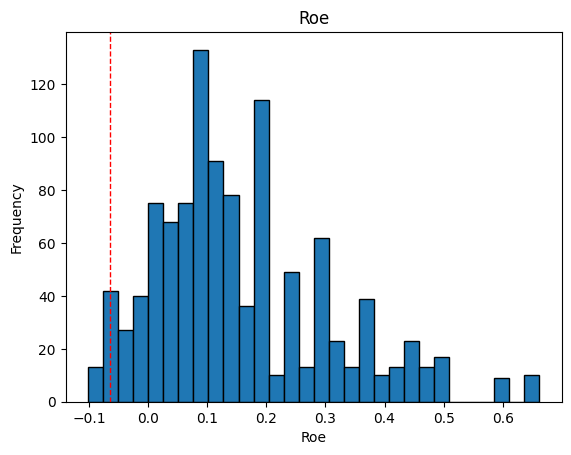

pe_ratio diagram is missing due to error.


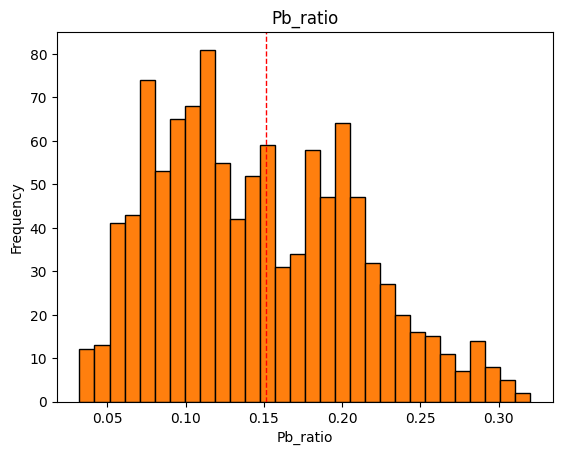

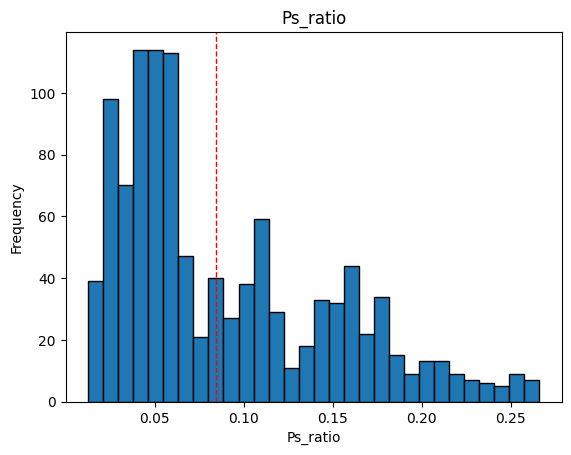

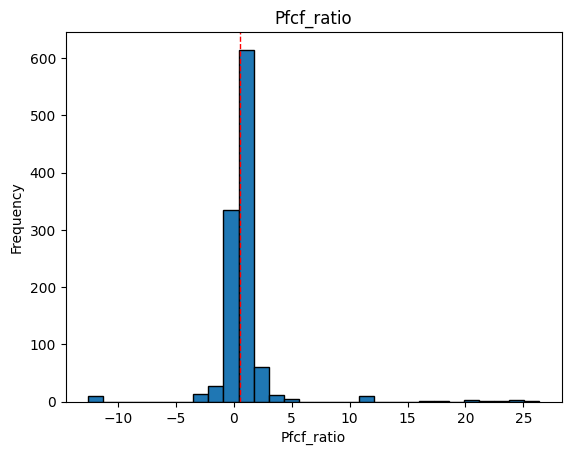

In [43]:
for column in merged_nok.columns[-8:]:
    try:
        plt.hist(merged_nok[column].values, bins=30, edgecolor='black')
        plt.axvline(merged_nok[column].iloc[-1], color='r', linestyle='dashed', linewidth=1)
        
        plt.xlabel(column.capitalize())
        plt.ylabel('Frequency')
        plt.title(column.capitalize())
        
        plt.show()
    except:
        print(column + " diagram is missing due to error.")